## TIME SERIES ANALYSIS
## Goal: Find outliers, trends and periodicity in the MTA turnstyle data

Populating the interactive namespace from numpy and matplotlib


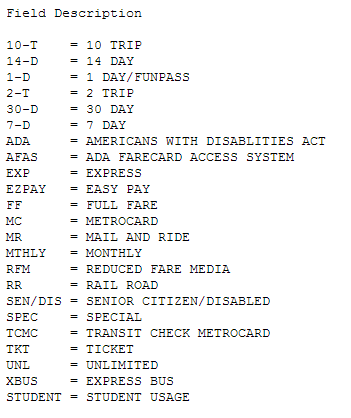

In [2]:
from __future__ import print_function, division
import os
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

### Data

In [3]:
# ove the downloaded data to PUI data
print("PUIDATA", os.getenv("PUIDATA"))

PUIDATA /nfshome/ys3226/PUIdata


In [4]:
#create the env variable if missing
os.environ["PUIDATA"] = "%s/PUIDATA"%os.getenv("HOME")

print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/ys3226/PUIDATA


In [5]:
mtaRides = np.load("%s/MTA_Fare.npy"%os.getenv("PUIDATA"))

In [8]:
print ("MTA array shape:", mtaRides.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mtaRides,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


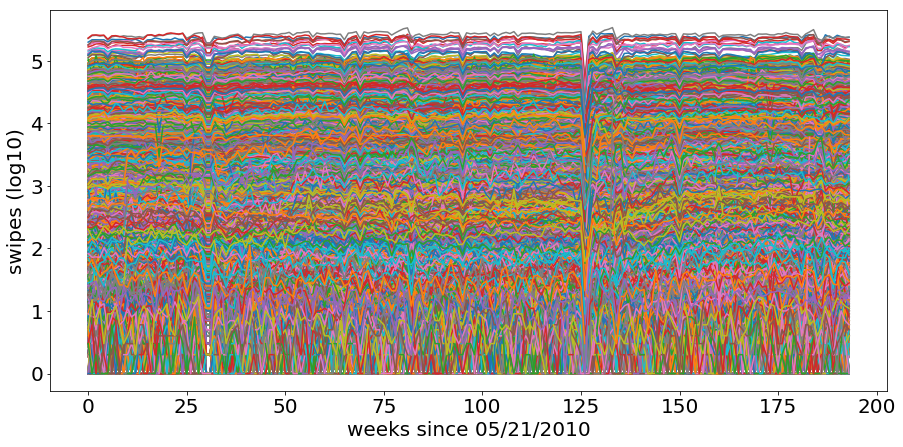

In [9]:
fig = plt.figure(figsize = (15,7))

for i in range(mtaRides.shape[0]):
    for j in range(mtaRides.shape[1]):
        plt.plot(np.log10(mtaRides[i,j,:]))

plt.xlabel('weeks since 05/21/2010', fontsize=20)
plt.ylabel('swipes (log10)', fontsize=20)
plt.show()

                    Figure 1: Time series for all ride types and all stations in log space

## Task 4. Fourier transform:

### Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

#### from the numpy package you will nees only the np.fft.rfft() to take the fourier transform
#### and np.fft.rfftfreq() to create a meaningful x axis

In [10]:
mta = mtaRides

In [11]:
mta = mta.astype('float')
mta[mta == -1] = NaN

In [12]:
mta.shape

(600, 23, 194)

In [16]:
mta_event = np.nanmean(mta, axis=1)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [17]:
mta_event.shape

(600, 194)

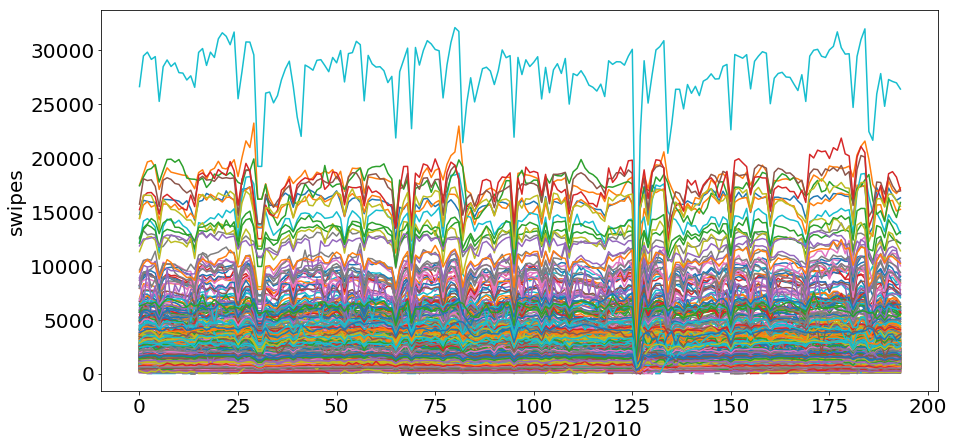

In [22]:
fig = plt.figure(figsize = (15,7))

for i in range(mta_event.shape[0]):
    plt.plot(mta_event[i,:])

plt.xlabel('weeks since 05/21/2010', fontsize=20)
plt.ylabel('swipes', fontsize=20)
plt.show()    

                        Figure 2: Time series of the average of ride types in all stations in log space

In [50]:
## get rid of NaN's
mta_rides = mta_event[mta_event.std(1) > 0]

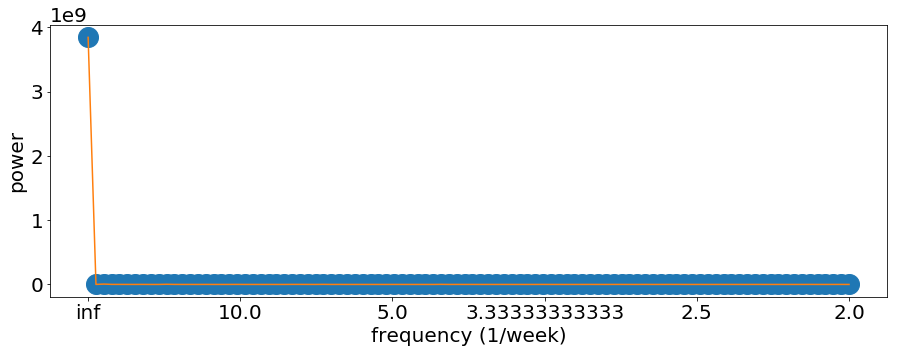

In [52]:
## check for the first station's power series
N = len(mta_rides[0])
f = np.abs(np.fft.rfft(mta_rides[0]))**2
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(N, 1.0), (f), 'o', ms=20)
ax.plot(np.fft.rfftfreq(N, 1.0), (f), '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.ylabel("power", fontsize=20)
pl.xlabel("frequency (1/week)", fontsize=20);

                        Figure 3: FT power spectrum of the first station including the infinite power

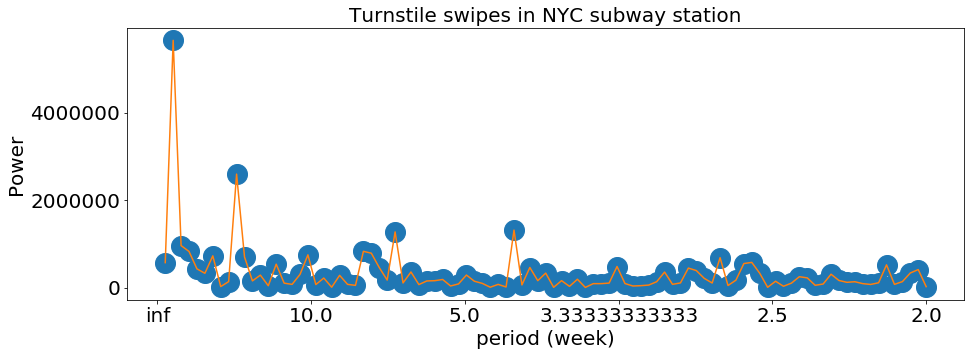

In [63]:
## check for the first station's power series starting at[1] to omit first infinite power
f = np.abs(np.fft.rfft(mta_rides[0]))**2
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=20)
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')

# changing the labels on the x ticks to see the period instead of frequency
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (week)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("Turnstile swipes in NYC subway station", fontsize=20);

                               Figure 4: FT power spectrum of the first station excluding the infinite power

In [128]:
len(mta_rides)

417

In [129]:
## create a list for maximum powers of each station 
maxes = []
for i in range(len(mta_rides)):
    f = np.abs(np.fft.rfft(mta_rides[i]))**2
    maxes.append(max(f[2:]))

In [135]:
## take the four subway stations having most prominent powers by their indices
## I excerpted the method from some google search  
a = np.array(maxes)
ind = np.argpartition(a, -4)[-4:]
ind

array([299, 133, 175,  28])

### Comment: So, four indices above show the subway station having most prominent periodic trend on an anual period.

In [136]:
## see the numeric values of these four incdices 
a[ind]

array([  1.14421643e+10,   1.73783672e+10,   1.79941057e+10,
         1.24858130e+10])

### Checking one example out of these 4 station ( the one at the index[299] )

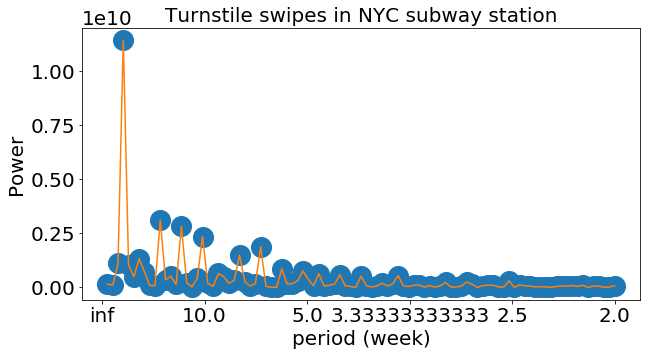

In [140]:
f = np.abs(np.fft.rfft(mta_rides[299]))**2
fig=pl.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=20)
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')

# changing the labels on the x ticks to see the period instead of frequency
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (week)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("Turnstile swipes in NYC subway station", fontsize=20);

     Figure 5: FT power spectrum of the station at index[299] showing very strong peak of power at the 4. rank  

In [141]:
np.where(f[2:] == f[2:].max())[0] + 2

array([4])

In [149]:
print ("most important period: ")
print ("%.2f weeks"%(1.0 / np.fft.rfftfreq(N, 1.0)[4]))

most important period: 
48.50 weeks


### Comment: Most important period give us an insightful information by saying the events are observable most significantly in a 48 week period, which is almost 1 year. This represent a good one year (annual) periodicity. 